<a href="https://colab.research.google.com/github/SaltyEl/DiabetesPredictor/blob/main/DiabetesPredictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting Diabetes

### Purpose and Goals

The purpose of this web application is to provide a tool for identifying diabetes and to explain which machine learning model was chosen to power the tool and why. The purpose of this diabetes identification tool is to identify clients with diabetes who may have previously been missed so that they can begin proper treatment.

### Definition of Success
This tool was originally intended to identify with at least 75% accuracy whether or not a client is likely to have diabetes. This tool performs above that metric, with a cross-validated accuracy score of around 77%.

### Data Dictionary

* Pregnancies: Number of times the person has been pregnant.

* Glucose: The results of an oral glucose tolerance test at 2 hours (Glucose in milligrams/deciliter).

* BloodPressure: The diastolic blood pressure in mmHg

* SkinThickness: Tricep skin fold thickness in millimeters.

* Insulin: 2-hour post glucose insulin levels (a predictor for insulin resistance).

* BMI: The body mass index (a value derived from weight and height).
    * Less than 18.5 is underweight.
    * 18.5 - 24.9 is normal.
    * 25 - 29.9 is overweight.
    * 30 - 34.9 is obese.
    * Greater than 35 is morbidly obese.

* DiabetesPedigreeFunction: The diabetes pedigree function is calculated using the client's age and diabetic family history.

* Age: The age of the person.

* Outcome: 1 means the person has diabetes and 2 means the person does not have diabetes.

In [ ]:
# Import tools
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import ipywidgets as widgets
from IPython.display import display

# Import models
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier

# Import Model Evaluators
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import RocCurveDisplay, confusion_matrix

## Load and Explore Data

Explore the topmost portion of the data to gain an understanding of dependent and independent variables:

In [ ]:
diabetes_data = pd.read_csv('diabetes.csv')
diabetes_data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Number of client's in the data:

In [ ]:
len(diabetes_data)

768

Check for any missing data:

In [ ]:
diabetes_data.isna().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

Check data types for any types that would need to be converted:

In [ ]:
diabetes_data.dtypes

Pregnancies                   int64
Glucose                       int64
BloodPressure                 int64
SkinThickness                 int64
Insulin                       int64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
Outcome                       int64
dtype: object

Lets view how many of each outcome exists:

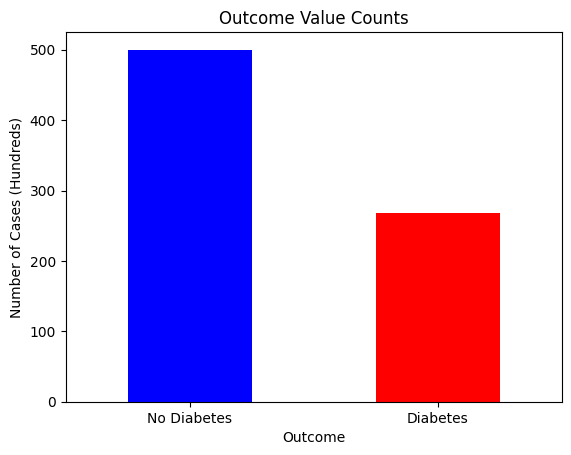

In [ ]:
diabetes_data["Outcome"].value_counts().plot(kind="bar", color=["Blue","Red"], legend=False)
plt.title("Outcome Value Counts")
plt.xlabel("Outcome")
plt.ylabel("Number of Cases (Hundreds)")
plt.xticks(ticks=[0, 1],
           labels=["No Diabetes", "Diabetes"],
          rotation=0);

Let's visualize how Glucose and Insulin levels (from Glucose Tolerance Test) impact the Outcome

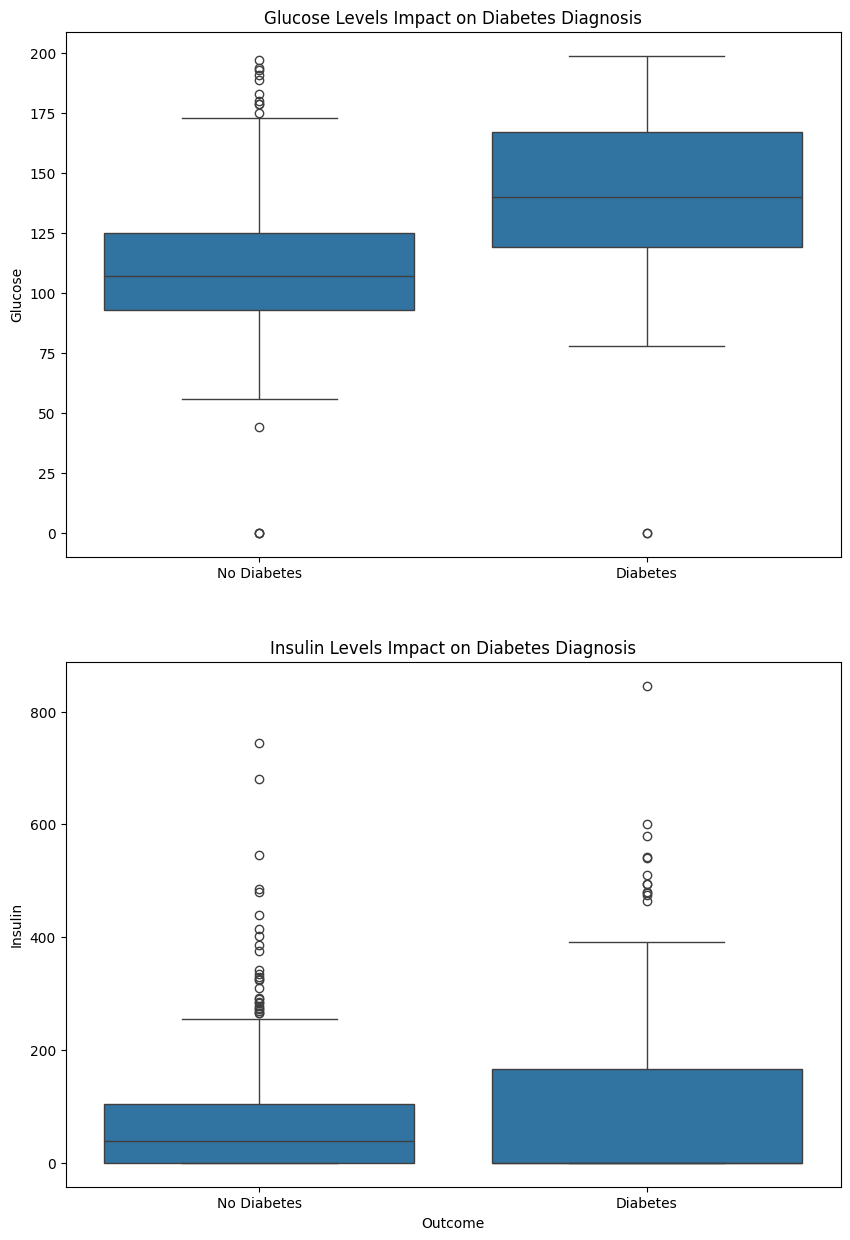

In [ ]:
# Create a figure and 2 axes.
fig, (ax1, ax2) = plt.subplots(2, 1, figsize= (10,15))

# Set X_ticks and X_labls
x_ticks = [0,1]
x_labels = ["No Diabetes", "Diabetes"]

# Create a boxplot for each set of data and assign it to the appropriate axis.
sns.boxplot(x=diabetes_data.Outcome, y=diabetes_data.Glucose, ax=ax1)
sns.boxplot(x=diabetes_data.Outcome, y=diabetes_data.Insulin, ax=ax2)

# Customize ax1
ax1.set_title("Glucose Levels Impact on Diabetes Diagnosis")
ax1.set_xticks(ticks=x_ticks, labels=x_labels)
ax1.set_xlabel('')

# Customize ax2
ax2.set_title("Insulin Levels Impact on Diabetes Diagnosis")
ax2.set_xticks(ticks=x_ticks, labels=x_labels)

# Set xlabel and show plot.
plt.xlabel('Outcome')
plt.show();

Lets check the distribution of age in the data provided:

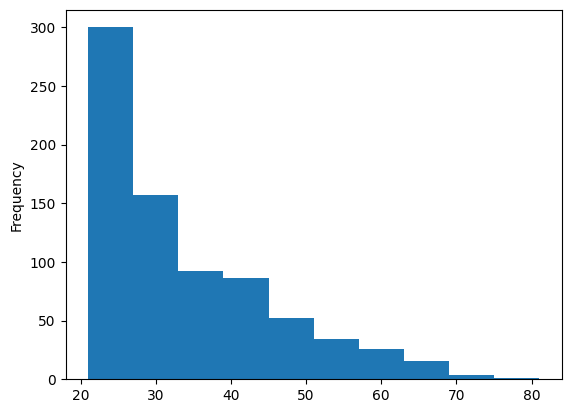

In [ ]:
diabetes_data.Age.plot(kind='hist');

## Prepare Data For Machine Learning

DataFrames are created to store the dependent variables and independent variables separately.

The Data is then split into training and testing sets.

In [ ]:
# Create dependent and independent data to work with.
x = diabetes_data.drop("Outcome", axis=1)
y = diabetes_data["Outcome"]

In [ ]:
# Split data into training and test data.
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

## Test Models

Models being tested include:
* Logistic Regression
* K Nearest Neighbors Classifier
* Random Forest Classifier
* Linear SVC

Each model is scored on it's accuracy, and the results are below.

In [ ]:
# Put Models in a dict
models = {"Logistic Regression": LogisticRegression(max_iter=1000),
         "KNN":KNeighborsClassifier(),
         "Random Forest": RandomForestClassifier(),
         "Linear SVC":LinearSVC(dual=False)}

# Make a dict (using dict comprehension) to create and keep model scores.
model_scores = {name: model.fit(x_train, y_train).score(x_test, y_test) for name, model in models.items()}

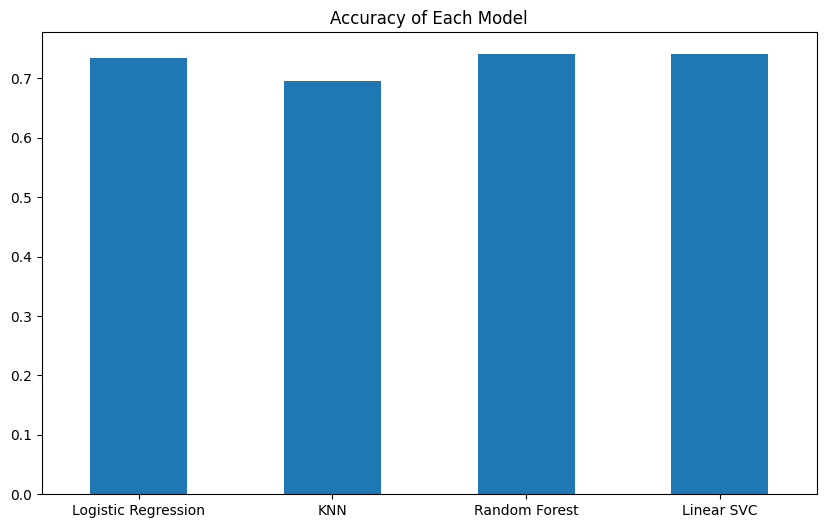

In [ ]:
# Visualize each models performance
model_scores_df = pd.DataFrame(model_scores, index=["Accuracy"])
model_scores_df.T.plot.bar(legend=False, figsize=(10,6))
plt.title("Accuracy of Each Model")
plt.xticks(rotation=0);

## Evaluate Best Models Beyond Accuracy

Each model above performs adequately, but the Logistic Regression and Linear SVC models stand out as the best (on average)

Evaluate the F1 Score, Recall, and Precision to see if either model can separate from the other in terms of performance.

A visual of the results is below.

In [ ]:
# Create a function that can create a cross-validation scoring report of F1, Recall, Precision and Accuracy
def cv_classification_report(model, x, y, num, scoring_list=None):
    if scoring_list is None:
        scoring_list = ["accuracy", "precision", "recall", "f1"]

    scoring_dict = {metric.title(): np.mean(cross_val_score(model, x, y, cv=num, scoring=metric)) for metric in scoring_list}

    return scoring_dict

In [ ]:
# Use function to obtain scores of the Logistic Regression and Linear SVC Model
LR_scoring_report = cv_classification_report(LogisticRegression(max_iter=1000), x, y, 5)
Linear_scoring_report = cv_classification_report(LinearSVC(dual=False), x, y, 5)

In [ ]:
LR_scoring_report

{'Accuracy': 0.7721925133689839,
 'Precision': 0.7196000559468052,
 'Recall': 0.5747030048916841,
 'F1': 0.6374328442978329}

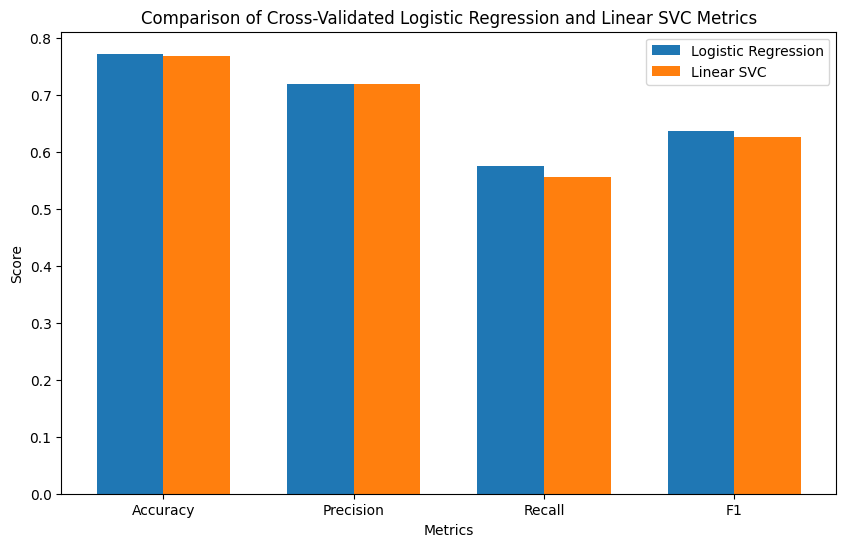

In [ ]:
# Let's visualize cross-validated metrics for Logistic Regression and Linear SVC

# Seperate values from keys
keys = list(LR_scoring_report.keys())
log_reg_values = list(LR_scoring_report.values())
lin_svc_values = list(Linear_scoring_report.values())

# Index and Bar width
index = np.arange(len(keys))
bar_width = 0.35

# Create a figure and 2 axes.
fig, ax = plt.subplots(figsize=(10,6))

ax.bar(index, log_reg_values, bar_width, label='Logistic Regression')
ax.bar(index + bar_width, lin_svc_values, bar_width, label='Linear SVC')
ax.legend()
ax.set_xlabel("Metrics")
ax.set_ylabel("Score")
ax.set_title("Comparison of Cross-Validated Logistic Regression and Linear SVC Metrics")
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(keys);

## Evaluate Logistic Regression Model Further

As shown above, a cross-validated version of Logistic Regression narrowly edges out a cross-validated version of Linear SVC in terms of Accuracy, Precision, Recall and F1. We will offically fit a Logistic Regression model to the data to be further evaluated and used in the application of identifying diabetic clients.

Further evaluate Logistic Regression Model using:
* ROC Curve and AUC Score
* Confusion Matrix

Visuals of metric curve are provided below.

In [ ]:
# Create, fit and predict the model

clf = LogisticRegression(max_iter=1000)
clf.fit(x_train, y_train)
y_preds = clf.predict(x_test)

The ROC Curve shows an Area Under Curve (AUC) score of 0.86

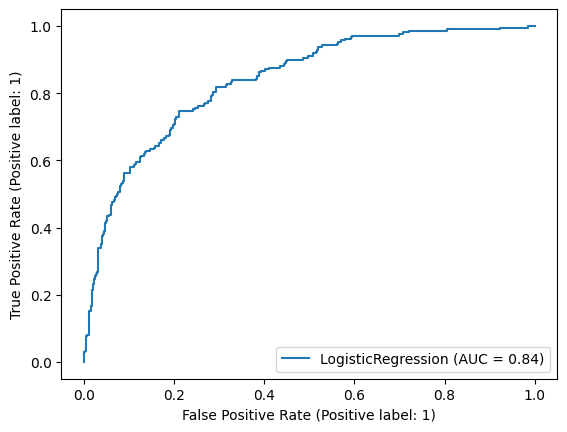

In [ ]:
# Create ROC Curve
RocCurveDisplay.from_estimator(clf, x_train, y_train);

The confusion matrix compares the number of True positives, false positive, true negatives and false negatives

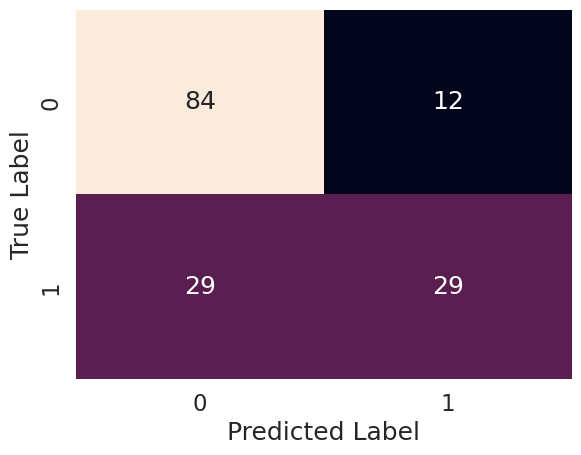

In [ ]:
# Create Confusion Matrix to evaluate tr
sns.set(font_scale=1.5)

fig, ax = plt.subplots()
ax = sns.heatmap(confusion_matrix(y_test, y_preds),
                annot=True,
                cbar=False)
plt.xlabel("Predicted Label")
plt.ylabel("True Label");

In [ ]:
diabetes_data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


## Tool For Diagnosis of Diabetes

Finally, I've provided the tool for diagnosis below.

Steps:
1. Fill the form out in its entirety
2. Hit Submit
3. The results will display below the submit button.
4. Repeat as desired.

Examples patients for use:
1. Patient 1: Pregnancies - 6, Glucose - 148, Blood Pressure - 72, Skin Thickness - 35, Insulin - 0, BMI - 33.6, DPF - 0.627, Age - 50.
2. Patient 2: Pregnancies - 3, Glucose - 170, Blood Pressure - 80, Skin Thickness - 33, Insulin - 0, BMI - 20.0, DPF - 0.333, Age - 25.
3. Patient 3: Pregnancies - 3, Glucose - 200, Blood Pressure - 70, Skin Thickness - 35, Insulin - 50, BMI - 26.0, DPF - 0.5, Age - 30.

In [ ]:
# Style and Layout Presets
style = {'description_width': 'initial'}
widget_layout = widgets.Layout(margin="5px 30px")
button_layout = widgets.Layout(margin="10px 30px")
label_layouts = widgets.Layout(margin = "10px 30px")

# Create Labels
title = widgets.Label(value="Diabetes Screening Form", layout=label_layouts, style=dict(
    font_weight='bold',
    font_size='20px'
))
result = widgets.Label(value='None', layout=label_layouts)

# Initialize widget objects appropriate for form.
pregnancies = widgets.IntSlider(min=0, max=20, description='Pregnancies:', style=style, layout=widget_layout)
glucose = widgets.BoundedIntText(min=0, max=200, description='Glucose (mg/dL):', style=style, layout=widget_layout)
blood_pressure = widgets.BoundedIntText(min=0, max=130, description='Diastolic Blood Pressure (mmHg):', style=style, layout=widget_layout)
skin_thickness = widgets.BoundedIntText(min=0, max=130, description='Skin Thickness (mm):', style=style, layout=widget_layout)
insulin = widgets.BoundedIntText(min=0, max=1000, description='Insulin:', style=style, layout=widget_layout)
bmi = widgets.BoundedFloatText(min=0, max=100, description='BMI:', style=style, layout=widget_layout)
dpf = widgets.BoundedFloatText(min=0, max=4, description='Diabetes Pedigree Function:', style=style, layout=widget_layout)
age = widgets.BoundedIntText(min=0, max=130, description='Age (years):', style=style, layout=widget_layout)

# Create a Submit Button
button = widgets.Button(layout=button_layout, description="Submit")

# Create a Box to hold form objects.
attribute_box = widgets.Box([title, pregnancies, glucose, blood_pressure, skin_thickness, insulin, bmi, dpf, age, button, result],
                   layout=widgets.Layout(flex_flow="column", align_items="center", border="5px solid black", width="fit-content",
                                        margin_left="auto"))

# Create Diabetes Predictor Function using the Logistic Regression Model
def predict_diabetes(preg, gluc, bp, skin_thickness, insulin, BMI, DPF, age):
    prediction = clf.predict(pd.DataFrame({'Pregnancies':preg,
                          'Glucose': gluc,
                          'BloodPressure': bp,
                          'SkinThickness': skin_thickness,
                          'Insulin': insulin,
                          'BMI': BMI,
                          'DiabetesPedigreeFunction': DPF,
                          'Age': age}, index=[0]))
    if prediction[0] == 1:
        return "This client's outcome is " + str(prediction[0]) + ". They are likely to have diabetes."
    else:
        return "This client's outcome is " + str(prediction[0]) + ". They are unlikely to have diabetes."

# Define Button Function
def on_button_clicked(b):
    result.value = ""  # Clear previous result
    # Extract values from widgets
    preg = pregnancies.value
    gluc = glucose.value
    bp = blood_pressure.value
    skin = skin_thickness.value
    ins = insulin.value
    bmi_val = bmi.value
    dpf_val = dpf.value
    age_val = age.value

    # Call predict_diabetes function
    prediction = predict_diabetes(preg, gluc, bp, skin, ins, bmi_val, dpf_val, age_val)

    # Display the result
    result.value = prediction

# Create the on_click action of the Submit Button
button.on_click(on_button_clicked)

# Display the Box
attribute_box

Box(children=(Label(value='Diabetes Screening Form', layout=Layout(margin='10px 30px')), IntSlider(value=0, de…